# Mount to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Improt required libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import mne
import re
from matplotlib import pyplot as plt
import scipy.io as sio
import numpy as np
import pickle as pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn import metrics
from scipy import signal
import os
import math

import tensorflow as tf
import keras
from tensorflow.keras.utils import to_categorical
# from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, LSTM, Conv2D, MaxPooling2D, RepeatVector
import warnings
warnings.filterwarnings('ignore')

# Data Pre-processing

In [ ]:
dataset_path = '/content/drive/My Drive/Major/auditory-evoked-potential-eeg-biometric-dataset-1.0.0/Filtered_Data/'
channel_names = ['P4', 'Cz', 'F8', 'T7']  # Specify the EEG channel names

In [ ]:
def load_eeg_column_data(directory, column_name):
    data = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)

            df = pd.read_csv(filepath)

            num_rows = len(df)
            # If the number of rows is less than the specified maximum
            if num_rows < 24000:
                print(f"Skipping file {filename} as it doesn't have enough rows.")
                continue
            df = df.head(23800)

            if column_name in df.columns:
                eeg_data = df[column_name].values
            else:
                print(f"Column '{column_name}' not found in file {filename}. Skipping...")
                continue

            data.append(eeg_data)

            # Extract label from filename
            person_id = 0
            match = re.search(r's(\d+)_ex', filename)
            if match:
                person_id = int(match.group(1))  # Convert the extracted number to an integer
            else:
                print("No match found.")
            label = person_id - 1
            labels.append(label)


    data = np.array(data)
    labels = np.array(labels)

    return data, labels

In [ ]:
eeg_Data, labels = load_eeg_column_data(dataset_path, channel_names[0])

print("EEG data shape:", eeg_Data.shape)
print("Labels shape:", labels.shape)

Skipping file s03_ex06.csv as it doesn't have enough rows.
Skipping file s20_ex01_s03.csv as it doesn't have enough rows.
Skipping file s19_ex01_s03.csv as it doesn't have enough rows.
EEG data shape: (237, 4, 23800)
Labels shape: (237,)


In [ ]:
eeg_Label = []
for i in labels:
  eeg_Label.append(i)

# Change the label from subject_id to categorial label
y = to_categorical(eeg_Label)

y.shape

(237, 20)

# Feature Extraction

# Feature Extraction

In [ ]:
# Spectogram
fs = 200

size_dataset = len(eeg_Data)
nperseg = 400
noverlap = 200
f_size = math.ceil(((nperseg + 1)/2))
t_size = int((eeg_Data[0].size - noverlap ) / (nperseg - noverlap))
X_full = np.ndarray(shape=(size_dataset, f_size, t_size, 3))

for i in range(0, size_dataset):
  for j in range(0,3):
    X = eeg_Data[i]
    f, t, Sxx = spectrogram(X, fs, nperseg = nperseg, noverlap = noverlap, mode='complex')
    X_full[i, :, :, j] = Sxx

In [ ]:
X_full = np.array(X_full)

X_full.shape

(474, 201, 118, 3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, shuffle=True, random_state=42)

X_train /= 255
X_test /= 255

In [ ]:
num_classes = 20

input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
input_shape

(201, 118, 3)

# Model training

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights based on imbalance ratio
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)

# Convert class_weights array to a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3),strides=(1, 1),activation='relu',input_shape=input_shape))
# model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(64, (3, 3),activation='relu'))
# model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(RepeatVector(4))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 199, 116, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 58, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 56, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 28, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 48, 28, 64)        0         
                                                                 
 flatten (Flatten)           (None, 86016)             0

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer ="Adam", loss =keras.losses.categorical_crossentropy, metrics=['accuracy'])
m=model.fit(X_train, y_train,epochs=100,batch_size=256,verbose=1,validation_data=(X_test, y_test), callbacks =[es, mc])

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 2.9958 - accuracy: 0.0422 
Epoch 1: val_accuracy improved from -inf to 0.04211, saving model to best_model.h5
2/2 [==============================] - 62s 31s/step - loss: 2.9958 - accuracy: 0.0422 - val_loss: 2.9984 - val_accuracy: 0.0421
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 2.9935 - accuracy: 0.0422 
Epoch 2: val_accuracy did not improve from 0.04211
2/2 [==============================] - 41s 14s/step - loss: 2.9935 - accuracy: 0.0422 - val_loss: 3.0058 - val_accuracy: 0.0316
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 2.9888 - accuracy: 0.0554 
Epoch 3: val_accuracy did not improve from 0.04211
2/2 [==============================] - 40s 15s/step - loss: 2.9888 - accuracy: 0.0554 - val_loss: 3.0072 - val_accuracy: 0.0316
Epoch 4/100
2/2 [==============================] - ETA: 0s - loss: 2.9857 - accuracy: 0.0660 
Epoch 4: val_accuracy did not improve from 0.04211
2/2 

In [ ]:
saved_model = load_model('best_model.h5')

# Test model

In [ ]:
_, train_f1 = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_f1 = saved_model.evaluate(X_test, y_test, verbose=0)

print(test_f1)

0.9789473414421082


# Plot metrics

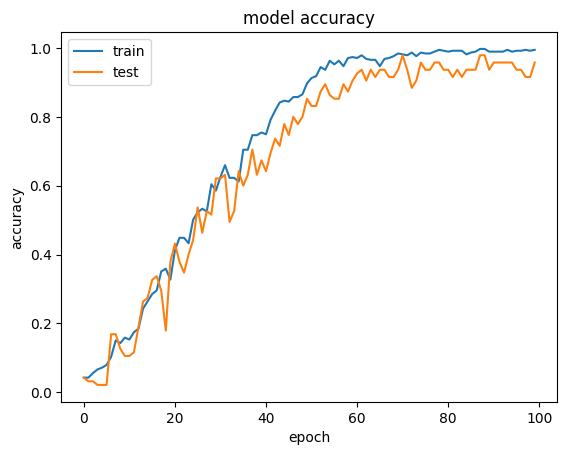

In [ ]:
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
y_test1=np.argmax(y_test, axis=1)

y_pred_saved = saved_model.predict(X_test)
y_pred_saved=np.argmax(y_pred_saved,axis=1)

print(metrics.classification_report(y_test1,y_pred_saved))

3/3 [==============================] - 5s 1s/step
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         3
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         4
          11       1.00      1.00      1.00         5
          12       0.71      1.00      0.83         5
          13       1.00      1.00      1.00         7
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         6
          16       1.00      1.

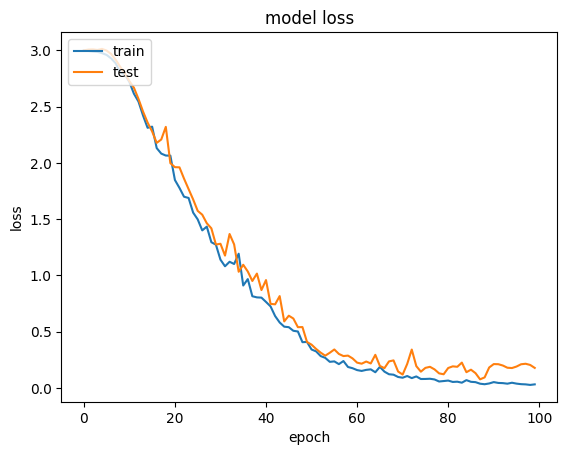

In [ ]:
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save model to Drive

In [ ]:
saved_model = load_model('best_model.h5')
saved_model.save('/content/drive/My Drive/saved_models/AEP_P4.h5')